## Harmonize LAI Time Series

In [1]:
# import libraries
import os
import glob
import pathlib
import xarray as xr
import geopandas as gpd
import odc.stac
import rasterio
import pandas as pd
import warnings
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# Prepare overlapping AVHRR time series: 2000 - 2005

In [5]:
# load LAI dataset of one day as example
lai_ex = xr.open_dataset("./Raw/LAI_FAPAR_AVHRR/2000/c3s_LAI_20000810000000_GLOBE_AVHRR-NOAA14_V1.0.1.area-subset.55.2.15.2.47.5.45.nc", 
                     decode_coords="all", 
                     decode_times=True)

In [6]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [7]:
# check if crs matches data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# create mask of research area using the dimensions of the exemplary lai data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=lai_ex.odc.geobox.shape,
                                            transform=lai_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [9]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [10]:
# create loop to process all datasets
for year in range(2000, 2006):

    # open 10-daily netCDF datasets of corresponding year
    directory = f"./Raw/LAI_FAPAR_AVHRR/{year}"
    files = glob.glob(os.path.join(directory, "*LAI*.nc"))

    for f in range(len(files)):
        file = files[f]
        
        lai = xr.open_dataset(file, decode_coords = "all", decode_times = True)

        # apply mask of research area to dataset 
        lai_ger = lai.where(~ger_mask)

        # set missing values to NA
        lai_ger['LAI'] = lai_ger['LAI'].where(lai_ger['LAI'] != 65535, np.nan)

        # extract quality flag pixel values as dataframe
        df_qa_pixelvalues = lai_ger.QFLAG.to_dataframe()

        # count frequency of pixel values and extract to dataframe
        df_qa_freq = df_qa_pixelvalues["QFLAG"].value_counts().to_frame()

        # create new column with quality flag
        df_qa_freq["qa_flag"] = df_qa_freq.index

        # reset index
        df_qa_freq.reset_index(drop = True, inplace = True)

        # rename column with counts
        df_qa_freq.rename({'count':'qa_flag_freq'},axis=1, inplace= True)

        # convert values to integer
        df_qa_freq["qa_flag"] = df_qa_freq["qa_flag"].astype("int16")

        # convert quality flags to binary to assess quality information stored in bits
        df_qa_freq['binary'] = df_qa_freq.qa_flag.apply(lambda x: format(int(x), '08b'))

        # create new columns with the different quality information stored in the bits to assess them seperately
        # source: https://dast.copernicus-climate.eu/documents/satellite-lai-fapar/D3.3.6-v1.1_PUGS_CDR_LAI_FAPAR_AVHRR_v1.0_PRODUCTS_v1.1.pdf 
        df_qa_freq['FAPAR Status'] = df_qa_freq['binary'].astype(str).str[0]
        df_qa_freq['LAI Status'] = df_qa_freq['binary'].astype(str).str[1]
        df_qa_freq['Input Status'] = df_qa_freq['binary'].astype(str).str[2]
        df_qa_freq['BRDF Algorithm Failure'] = df_qa_freq['binary'].astype(str).str[3]
        df_qa_freq['Snow Status'] = df_qa_freq['binary'].astype(str).str[4]
        df_qa_freq['No Data'] = df_qa_freq['binary'].astype(str).str[5]
        df_qa_freq['Land Sea Mask'] = df_qa_freq['binary'].astype(str).str[6:8]

        # extract all quality flag values that are fit for our purpose and should be kept in the dataset
        df_qa_tokeep = df_qa_freq[(df_qa_freq['LAI Status']=="0") & 
                                  (df_qa_freq['Input Status']=="0")]
        
        qa_tokeep = df_qa_tokeep["qa_flag"]

        # create a mask for the LAI datasets that only keeps pixels of good quality
        mask = lai_ger["QFLAG"].isin(qa_tokeep).compute()

        # mask dataset
        lai_masked = lai_ger["LAI"].where(mask, drop = False)

        # load forest area from ESA Landcover data for corresponding year
        forest_year = year

        forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                decode_coords = "all", 
                                decode_times= True)
        
        # drop crs coord as it leads to problems with resampling
        lai_masked = lai_masked.drop_vars('crs')

        # set crs for lai data again
        lai_masked.rio.write_crs(4326, inplace = True)

        # resample lai dataset to match resolution of forest dataset
        lai_match = lai_masked.rio.reproject_match(forest)

        # rename dimensions - they got renamed while resampling
        lai_match = lai_match.rename({'y':'lat', 'x':'lon'})

        # mask lai with forest data
        # broadleaved forest:
        lai_BL = lai_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                        drop = False)

        # needleleaved forest:
        NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
        lai_NL = lai_match.where(NL_mask, drop = False)

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        lai_BL.encoding.update(comp)
        lai_NL.encoding.update(comp)

        # save as netCDF4 datasets
        date = lai_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
        lai_BL.to_netcdf(f"./LAI/10Daily/{year}/LAI_{date}_BL.nc")
        lai_NL.to_netcdf(f"./LAI/10Daily/{year}/LAI_{date}_NL.nc")

    # print status
    print(f"Files for year {year} processed.")

Files for year 2000 processed.
Files for year 2001 processed.
Files for year 2002 processed.
Files for year 2003 processed.
Files for year 2004 processed.
Files for year 2005 processed.


In [11]:
# Calculate Monthly and Yearly values for 2000 - 2005 AVHRR

In [12]:
# create list with forest types
forest_types = ("NL", "BL")

In [13]:
# loop over years to calculate monthly and yearly mean lai values per pixel

for year in range(2000, 2006):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./LAI/10Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        lai = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        lai_mon_mean = lai.resample(time="1MS", skipna=True).mean("time")
        
        # calculate yearly mean values
        lai_year_mean = lai.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        lai_mon_mean.LAI.encoding.update(comp)
        lai_year_mean.LAI.encoding.update(comp)

        # save created datasets as netCDF4 files
        lai_mon_mean.to_netcdf(f"./LAI/Monthly_AVHRR_Overlap/LAI_mon_mean_{year}_{forest_type}.nc")
        lai_year_mean.to_netcdf(f"./LAI/Yearly_AVHRR_Overlap/LAI_year_mean_{year}_{forest_type}.nc")

In [14]:
# now, calculate linear regressions for different time aggregations and forest types
# load AVHRR and MODIS data for 2000 - 2005 (monthly and yearly, BL and NL)
# start with monthly lai of broadleaved forests to show workflow
dir = "./LAI/Monthly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*BL*.nc"))
lai_mon_avhrr_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./LAI/Monthly"
filelist = []
for year in range(2000, 2006):
    pattern = os.path.join(dir, f'*{year}_BL.nc')
    filelist.extend(glob.glob(pattern))
lai_mon_modis_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [15]:
lai_mon_avhrr_BL

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 72, lat: 2952, lon: 3510)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 576B 2000-01-01 2000-02-01 ... 2005-12-01
Data variables:
    LAI          (time, lat, lon) float32 3GB dask.array<chunksize=(3, 738, 878), meta=np.ndarray>

In [16]:
lai_mon_modis_BL

<xarray.Dataset> Size: 6GB
Dimensions:      (time: 71, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 568B 2000-02-01 2000-03-01 ... 2005-12-01
Data variables:
    LAI          (time, lat, lon) float64 6GB dask.array<chunksize=(2, 738, 878), meta=np.ndarray>

In [17]:
# January 2000 not available in MODIS dataset -> drop this month in AVHRR dataset
date_to_drop = pd.Timestamp("2000-01-01")
lai_mon_avhrr_BL = lai_mon_avhrr_BL.sel(time=lai_mon_avhrr_BL.time != date_to_drop)

In [18]:
lai_mon_avhrr_BL

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 71, lat: 2952, lon: 3510)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 568B 2000-02-01 2000-03-01 ... 2005-12-01
Data variables:
    LAI          (time, lat, lon) float32 3GB dask.array<chunksize=(3, 738, 878), meta=np.ndarray>

In [19]:
# calculate linear regression: Modis = a * AVHRR + b

In [20]:
# define a function to calculate linear regression between two xarray data arrays
# source: https://stackoverflow.com/questions/52108417/how-to-apply-linear-regression-to-every-pixel-in-a-large-multi-dimensional-array
def xr_regression(x, y, lag_x=0, lag_y=0, dim="time", alternative="two-sided"):
    """
    Source: https://stackoverflow.com/questions/52108417/how-to-apply-linear-regression-to-every-pixel-in-a-large-multi-dimensional-array

    Takes two xr.Datarrays of any dimensions (input data could be a 1D
    time series, or for example, have three dimensions e.g. time, lat,
    lon), and returns covariance, correlation, coefficient of
    determination, regression slope, intercept, p-value and standard
    error, and number of valid observations (n) between the two datasets
    along their aligned first dimension.

    Datasets can be provided in any order, but note that the regression
    slope and intercept will be calculated for y with respect to x.

    Inspired by:
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html

    Parameters
    ----------
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both
        sharing the same first dimension
    lag_x, lag_y : int, optional
        Optional integers giving lag values to assign to either of the
        data, with lagx shifting x, and lagy shifting y with the
        specified lag amount.
    dim : str, optional
        An optional string giving the name of the dimension on which to
        align (and optionally lag) datasets. The default is 'time'.
    alternative : string, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        The following options are available:

        * 'two-sided': slope of the regression line is nonzero
        * 'less': slope of the regression line is less than zero
        * 'greater':  slope of the regression line is greater than zero

    Returns
    -------
    regression_ds : xarray.Dataset
        A dataset comparing the two input datasets along their aligned
        dimension, containing variables including covariance, correlation,
        coefficient of determination, regression slope, intercept,
        p-value and standard error, and number of valid observations (n).

    """

    # Shift x and y data if lags are specified
    if lag_x != 0:
        # If x lags y by 1, x must be shifted 1 step backwards. But as
        # the 'zero-th' value is nonexistant, xarray assigns it as
        # invalid (nan). Hence it needs to be dropped
        x = x.shift(**{dim: -lag_x}).dropna(dim=dim)

        # Next re-align the two datasets so that y adjusts to the
        # changed coordinates of x
        x, y = xr.align(x, y)

    if lag_y != 0:
        y = y.shift(**{dim: -lag_y}).dropna(dim=dim)

    # Ensure that the data are properly aligned to each other.
    x, y = xr.align(x, y)

    # Compute data length, mean and standard deviation along dim
    n = y.notnull().sum(dim=dim)
    xmean = x.mean(dim=dim)
    ymean = y.mean(dim=dim)
    xstd = x.std(dim=dim)
    ystd = y.std(dim=dim)

    # Compute covariance, correlation and coefficient of determination
    cov = ((x - xmean) * (y - ymean)).sum(dim=dim) / (n)
    cor = cov / (xstd * ystd)
    r2 = cor**2

    # Compute regression slope and intercept
    slope = cov / (xstd**2)
    intercept = ymean - xmean * slope

    # Compute t-statistics and standard error
    tstats = cor * np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats

    # Calculate p-values for different alternative hypotheses.
    if alternative == "two-sided":
        pval = t.sf(np.abs(tstats), n - 2) * 2
    elif alternative == "greater":
        pval = t.sf(tstats, n - 2)
    elif alternative == "less":
        pval = t.cdf(np.abs(tstats), n - 2)
        
    # Wrap p-values into an xr.DataArray
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # Combine into single dataset
    regression_ds = xr.merge(
        [
            cov.rename("cov").astype(np.float32),
            cor.rename("cor").astype(np.float32),
            r2.rename("r2").astype(np.float32),
            slope.rename("slope").astype(np.float32),
            intercept.rename("intercept").astype(np.float32),
            pval.rename("pvalue").astype(np.float32),
            stderr.rename("stderr").astype(np.float32),
            n.rename("n").astype(np.int16),
        ]
    )

    return regression_ds

In [21]:
# apply function
regression_ds_lai_mon_BL = xr_regression(x = lai_mon_avhrr_BL.LAI, y = lai_mon_modis_BL.LAI)

In [22]:
# save dataset with regression values
regression_ds_lai_mon_BL.to_netcdf("./LAI/regression_ds_lai_mon_BL.nc")

In [23]:
# to get an overview, calculate harmonised AVHRR data for years 2000 - 2005 by applying linear regression equation
# and compare this to the regular avhrr and modis values
lai_mon_avhrr_BL_harm = lai_mon_avhrr_BL * regression_ds_lai_mon_BL.slope + regression_ds_lai_mon_BL.intercept

In [24]:
lai_mon_avhrr_BL_harm

<xarray.Dataset> Size: 3GB
Dimensions:      (lon: 3510, lat: 2952, time: 71)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 568B 2000-02-01 2000-03-01 ... 2005-12-01
    crs          int8 1B -127
Data variables:
    LAI          (time, lat, lon) float32 3GB dask.array<chunksize=(3, 738, 878), meta=np.ndarray>

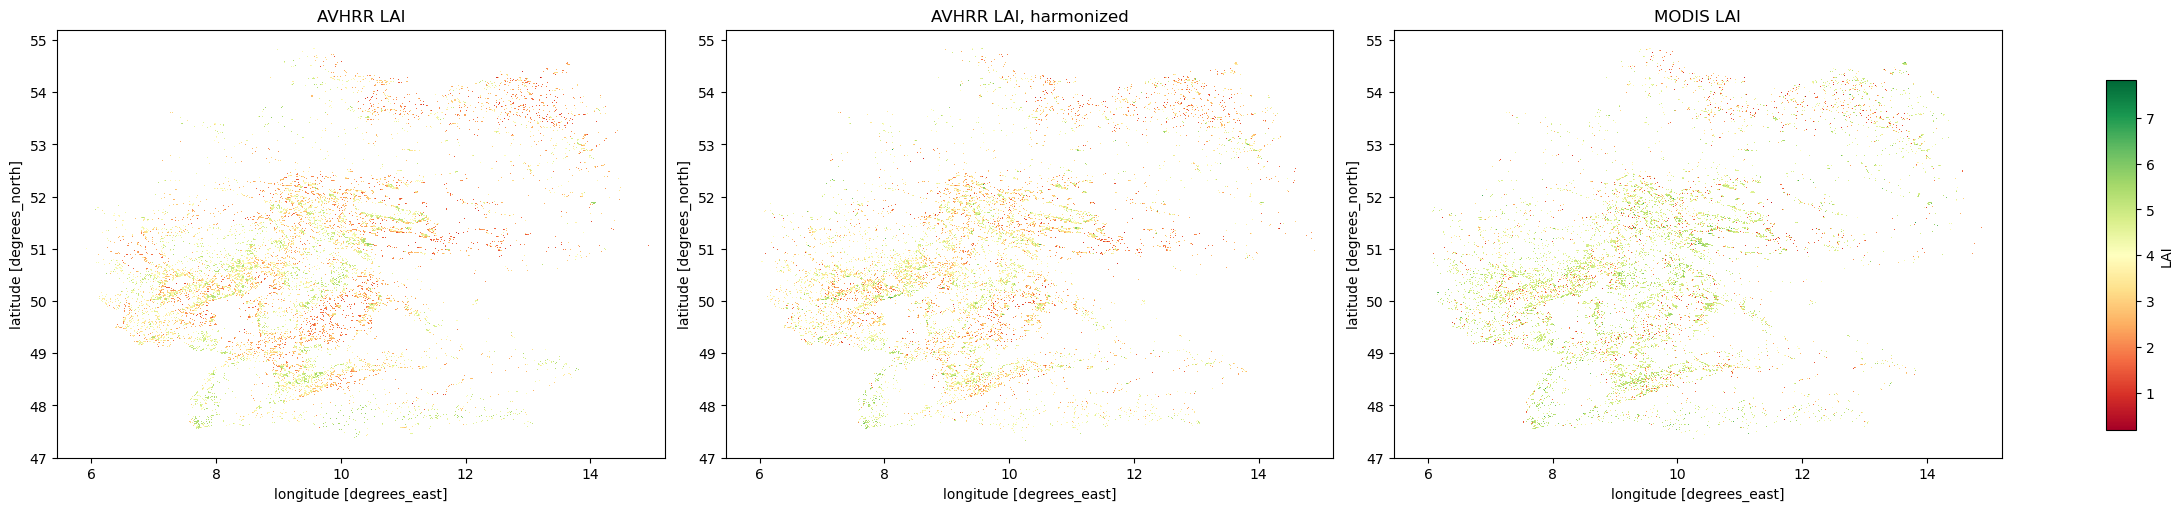

In [25]:
# plot an example
lai1 = lai_mon_avhrr_BL.LAI.sel(time="2005-08-01")
lai2 = lai_mon_avhrr_BL_harm.LAI.sel(time="2005-08-01")
lai3 = lai_mon_modis_BL.LAI.sel(time="2005-08-01")

# get global min and max across the three datasets for one specific time to set up a shared legend
vmin = min(lai1.min().compute().item(),
           lai2.min().compute().item(),
           lai3.min().compute().item())

vmax = max(lai1.max().compute().item(),
           lai2.max().compute().item(),
           lai3.max().compute().item())

# create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), constrained_layout = True)

# plot with shared color scale
im0 = lai_mon_avhrr_BL.LAI.sel(time="2005-08-01").plot(ax=axs[0], cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=False)
lai_mon_avhrr_BL_harm.LAI.sel(time="2005-08-01").plot(ax=axs[1], cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=False)
lai_mon_modis_BL.LAI.sel(time="2005-08-01").plot(ax=axs[2], cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=False)

axs[0].set_title("AVHRR LAI")
axs[1].set_title("AVHRR LAI, harmonized")
axs[2].set_title("MODIS LAI")

# add one colorbar for all subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='vertical')
cbar.set_label("LAI")

plt.show()

In [27]:
# calculate linear regression equations for the rest of the lai datasets
# first, monthly lai values of needleleaved forest
dir = "./LAI/Monthly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*NL*.nc"))
lai_mon_avhrr_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./LAI/Monthly"
filelist = []
for year in range(2000, 2006):
    pattern = os.path.join(dir, f'*{year}_NL.nc')
    filelist.extend(glob.glob(pattern))
lai_mon_modis_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

#January 2000 not available in MODIS dataset -> drop this month in AVHRR dataset
date_to_drop = pd.Timestamp("2000-01-01")
lai_mon_avhrr_NL = lai_mon_avhrr_NL.sel(time=lai_mon_avhrr_NL.time != date_to_drop)

# apply function to calculate linear regression
regression_ds_lai_mon_NL = xr_regression(x = lai_mon_avhrr_NL.LAI, y = lai_mon_modis_NL.LAI)

# save dataset with regression values
regression_ds_lai_mon_NL.to_netcdf("./LAI/regression_ds_lai_mon_NL.nc")

In [28]:
# now, calculate linear regression equations for yearly lai values of broadleaved forest
dir = "./LAI/Yearly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*BL*.nc"))
lai_year_avhrr_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./LAI/Yearly"
filelist = []
for year in range(2000, 2006):
    pattern = os.path.join(dir, f'*{year}_BL.nc')
    filelist.extend(glob.glob(pattern))
lai_year_modis_BL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# apply function to calculate linear regression
regression_ds_lai_year_BL = xr_regression(x = lai_year_avhrr_BL.LAI, y = lai_year_modis_BL.LAI)

# save dataset with regression values
regression_ds_lai_year_BL.to_netcdf("./LAI/regression_ds_lai_year_BL.nc")

In [29]:
# and finally, calculate linear regression equations for yearly lai values of needleleaved forest
dir = "./LAI/Yearly_AVHRR_Overlap"
filelist = glob.glob(os.path.join(dir, "*NL*.nc"))
lai_year_avhrr_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

dir = "./LAI/Yearly"
filelist = []
for year in range(2000, 2006):
    pattern = os.path.join(dir, f'*{year}_NL.nc')
    filelist.extend(glob.glob(pattern))
lai_year_modis_NL = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# apply function to calculate linear regression
regression_ds_lai_year_NL = xr_regression(x = lai_year_avhrr_NL.LAI, y = lai_year_modis_NL.LAI)

# save dataset with regression values
regression_ds_lai_year_NL.to_netcdf("./LAI/regression_ds_lai_year_NL.nc")

In [30]:
# now, apply linear regression to the original (1981 - 1999) AVHRR datasets to harmonize the timeline between AVHRR and MODIS data
# start with monthly BL and NL lai
# create list with forest types
forest_types = ("NL", "BL")
for f in range(len(forest_types)):
    forest_type = forest_types[f]

    # open according dataset with linear regression values
    regression_ds = xr.open_dataset(f"./LAI/regression_ds_lai_mon_{forest_type}.nc", decode_coords = "all", decode_times = True)

    # open original avhrr monthly lai values for 1981 - 1999
    for year in range(1981, 2000):
        lai_original = xr.open_dataset(f"./LAI/Monthly/lai_mon_mean_{year}_{forest_type}.nc", decode_coords = "all", decode_times = True)

        # apply linear regression to original lai dataset to harmonize data
        lai_harmonized = lai_original * regression_ds.slope + regression_ds.intercept

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        lai_harmonized.LAI.encoding.update(comp)

        # save created datasets as netCDF4 files
        lai_harmonized.to_netcdf(f"./LAI/Monthly_harmonized/LAI_mon_mean_{year}_{forest_type}.nc")

In [31]:
# continue with yearly BL and NL lai
# create list with forest types
forest_types = ("NL", "BL")
for f in range(len(forest_types)):
    forest_type = forest_types[f]

    # open according dataset with linear regression values
    regression_ds = xr.open_dataset(f"./LAI/regression_ds_lai_year_{forest_type}.nc", decode_coords = "all", decode_times = True)

    # open original avhrr yearly lai values for 1981 - 1999
    for year in range(1981, 2000):
        lai_original = xr.open_dataset(f"./LAI/Yearly/lai_year_mean_{year}_{forest_type}.nc", decode_coords = "all", decode_times = True)

        # apply linear regression to original lai dataset to harmonize data
        lai_harmonized = lai_original * regression_ds.slope + regression_ds.intercept

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        lai_harmonized.LAI.encoding.update(comp)

        # save created datasets as netCDF4 files
        lai_harmonized.to_netcdf(f"./LAI/Yearly_harmonized/LAI_year_mean_{year}_{forest_type}.nc")

In [32]:
# now, spatially aggregate the harmonized timelines to get mean values for Germany and the federal states
# first, get values for broadleaved forest
# load all yearly lai values as one dataset
directory = f"./LAI/Yearly_harmonized"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
lai_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# calculate mean lai values per year for Germany
lai_yearly_spatial_means = lai_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

# drop unneeded columns
lai_yearly_spatial_means = lai_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

# rename column with lai value to show area
lai_yearly_spatial_means.rename({"LAI":"GER"}, axis=1, inplace=True)

In [33]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    lai_ex = lai_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=lai_ex.odc.geobox.shape,
                                                transform=lai_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly lai data
    lai_state = lai_yearly["LAI"].where(~state_mask)

    # calculate yearly mean lai of state and extract to dataframe
    lai_state_spatial_means = lai_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    lai_state_spatial_means = lai_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    lai_yearly_spatial_means[state] = lai_state_spatial_means["LAI"]   

In [34]:
lai_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,2.525204,2.582612,2.399827,2.500880,2.504741,2.306940,2.677146,1.895841,2.462504,2.222518,2.505752,2.940339,2.209894,2.780376,2.039652,2.115040,2.226976
1982-01-01,2.490037,2.577110,2.383053,2.508680,2.464755,2.183649,2.626784,1.838359,2.486547,2.155152,2.439700,2.943463,2.272738,2.772625,1.923056,1.951512,2.104107
1983-01-01,2.523427,2.596511,2.385262,2.509063,2.510108,2.194384,2.671940,1.885465,2.477590,2.225122,2.464309,2.939036,2.241030,2.774570,2.028848,2.102655,2.205671
1984-01-01,2.572468,2.601109,2.410367,2.593294,2.549465,2.210429,2.683435,1.864669,2.499577,2.316646,2.498848,2.940577,2.320180,2.790795,2.108248,2.198388,2.356110
1985-01-01,2.682188,2.628322,2.373814,2.718827,2.734556,2.387044,2.820472,2.235486,2.570873,2.449964,2.587715,2.899924,2.452756,2.779715,2.176845,2.385669,2.573715
1986-01-01,2.592130,2.602689,2.361823,2.630159,2.589832,2.228173,2.721103,1.975001,2.494959,2.351897,2.549388,2.928722,2.283083,2.787446,2.013160,2.213536,2.333438
1987-01-01,2.564448,2.609708,2.345873,2.555381,2.580396,2.298525,2.702141,1.864760,2.505092,2.254751,2.463704,2.948433,2.232553,2.773268,2.108434,2.205006,2.356577
1988-01-01,2.561831,2.592839,2.324194,2.553662,2.574645,2.226208,2.698753,1.915740,2.474308,2.290255,2.490620,2.960539,2.277413,2.803555,2.063986,2.125512,2.295534
1989-01-01,2.580633,2.585155,2.368399,2.614817,2.615142,2.160799,2.714655,1.954918,2.519659,2.332496,2.518324,2.899175,2.421460,2.791151,2.025750,2.121647,2.259270


In [35]:
# save as csv dataset
lai_yearly_spatial_means.to_csv("./Tables/Spatial_Means/LAI_Yearly_Spatial_Means_BL_harmonized.csv")

In [36]:
# now take the same steps for needleleaved forest
# load all yearly lai values as one dataset
directory = f"./LAI/Yearly_harmonized"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
lai_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

# calculate mean lai values per year for Germany
lai_yearly_spatial_means = lai_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

# drop unneeded columns
lai_yearly_spatial_means = lai_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

# rename column with lai value to show area
lai_yearly_spatial_means.rename({"LAI":"GER"}, axis=1, inplace=True)

In [37]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    lai_ex = lai_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=lai_ex.odc.geobox.shape,
                                                transform=lai_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly lai data
    lai_state = lai_yearly["LAI"].where(~state_mask)

    # calculate yearly mean of state and extract to dataframe
    lai_state_spatial_means = lai_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    lai_state_spatial_means = lai_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    lai_yearly_spatial_means[state] = lai_state_spatial_means["LAI"]   

In [38]:
lai_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,2.063093,1.893293,1.929004,2.331764,2.010070,1.845573,2.355840,1.794167,2.117114,1.950176,2.344782,2.643788,1.894248,2.439381,2.082026,1.871983,1.989544
1982-01-01,2.008051,1.860344,1.932562,2.321507,1.950190,1.770015,2.334555,1.691281,2.139344,1.847042,2.323609,2.633651,1.956353,2.454008,2.032477,1.715625,1.851845
1983-01-01,2.047911,1.895562,1.937934,2.328830,2.011991,1.865150,2.350197,1.719366,2.146627,1.919373,2.323380,2.615748,1.971170,2.438799,2.053708,1.804185,1.891385
1984-01-01,2.068629,1.899226,1.930855,2.353857,2.029260,1.838542,2.365952,1.751049,2.143617,1.956277,2.345071,2.616602,1.999636,2.449943,2.079916,1.821715,1.960981
1985-01-01,2.118821,1.913121,1.936941,2.403792,2.122581,1.808574,2.391149,1.853933,2.201815,2.011897,2.356635,2.569288,2.148522,2.418942,2.097865,1.843068,2.070344
1986-01-01,2.053044,1.871074,1.933328,2.368043,2.012942,1.756183,2.367588,1.754803,2.148233,1.938562,2.351430,2.590864,1.959455,2.445005,2.040259,1.796072,1.937485
1987-01-01,2.060367,1.890160,1.929939,2.336013,2.037937,1.769042,2.359686,1.704117,2.152689,1.896257,2.336818,2.647168,1.925645,2.451229,2.077154,1.798675,1.980621
1988-01-01,2.038452,1.874526,1.933740,2.328878,1.988033,1.835954,2.348382,1.775448,2.116908,1.915468,2.344888,2.604484,2.002656,2.438463,2.052070,1.779533,1.926009
1989-01-01,2.060691,1.864578,1.922278,2.387723,2.056857,1.938913,2.370476,1.755187,2.146840,1.938237,2.347584,2.555650,2.090139,2.415138,2.054466,1.733149,1.916567


In [39]:
# save as csv dataset
lai_yearly_spatial_means.to_csv("./Tables/Spatial_Means/LAI_Yearly_Spatial_Means_NL_harmonized.csv")